Found 4415 images belonging to 10 classes.
Found 1337 images belonging to 10 classes.
Found 1362 images belonging to 10 classes.
Number of classes: 10
Training DenseNet121...
Epoch 1/50
137/137 [==============================] - 129s 910ms/step - loss: 2.9399 - accuracy: 0.2343 - mAP: 0.6754 - val_loss: 1.4286 - val_accuracy: 0.5084 - val_mAP: 0.8831
Epoch 2/50
137/137 [==============================] - 121s 888ms/step - loss: 2.0713 - accuracy: 0.3630 - mAP: 0.7987 - val_loss: 1.2080 - val_accuracy: 0.5686 - val_mAP: 0.9171
Epoch 3/50
137/137 [==============================] - 119s 868ms/step - loss: 1.8129 - accuracy: 0.4230 - mAP: 0.8343 - val_loss: 1.1838 - val_accuracy: 0.5945 - val_mAP: 0.9204
Epoch 4/50
137/137 [==============================] - 119s 867ms/step - loss: 1.6447 - accuracy: 0.4483 - mAP: 0.8555 - val_loss: 1.1292 - val_accuracy: 0.6059 - val_mAP: 0.9277
Epoch 5/50
137/137 [==============================] - 125s 916ms/step - loss: 1.5856 - accuracy: 0.4684 - mAP: 0.

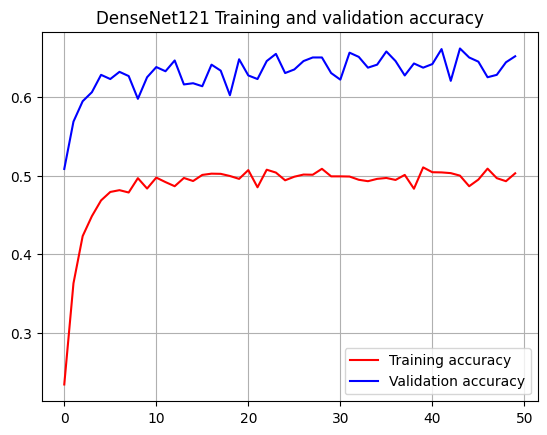

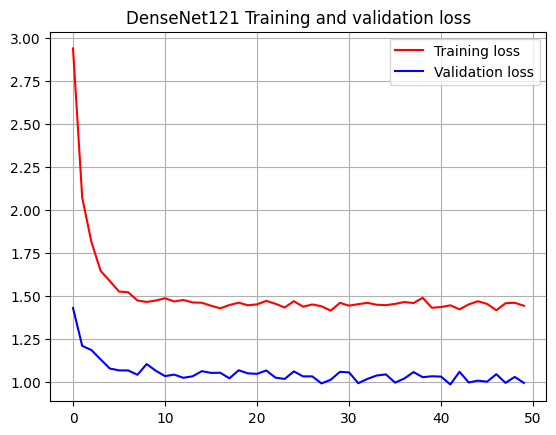

43/43 [==============================] - 30s 651ms/step


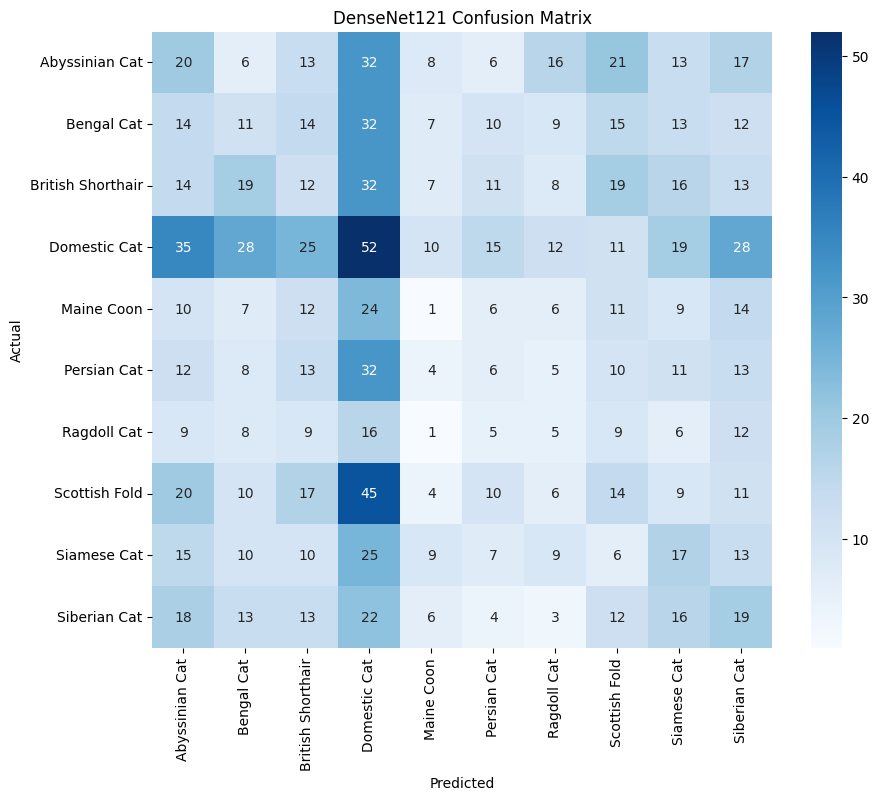

DenseNet121 Classification Report:
                   precision    recall  f1-score   support

   Abyssinian Cat       0.12      0.13      0.13       152
       Bengal Cat       0.09      0.08      0.09       137
British Shorthair       0.09      0.08      0.08       151
     Domestic Cat       0.17      0.22      0.19       235
       Maine Coon       0.02      0.01      0.01       100
      Persian Cat       0.07      0.05      0.06       114
      Ragdoll Cat       0.06      0.06      0.06        80
    Scottish Fold       0.11      0.10      0.10       146
      Siamese Cat       0.13      0.14      0.14       121
     Siberian Cat       0.12      0.15      0.14       126

         accuracy                           0.12      1362
        macro avg       0.10      0.10      0.10      1362
     weighted avg       0.11      0.12      0.11      1362

Training times (in seconds): {'DenseNet121': 6117.506508588791}
DenseNet121 Best validation accuracy: 0.6615853905677795


In [2]:
# Ensure TensorFlow and necessary packages are installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define data directories
train_data_dir = 'data/train'
val_data_dir = 'data/val'
test_data_dir = 'data/test'

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Check the number of classes
num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')

def create_model(base_model):
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Added dropout layer for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Define the models
models_dict = {
    'DenseNet121': create_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
}

# Compile the models
for model_name, model in models_dict.items():
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', AUC(name='mAP')])

# Train and evaluate the models
history_dict = {}
training_times = {}
for model_name, model in models_dict.items():
    print(f'Training {model_name}...')
    start_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    end_time = time.time()
    training_times[model_name] = end_time - start_time
    history_dict[model_name] = history

    # Evaluate the model
    test_loss, test_acc, test_mAP = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'{model_name} Test accuracy: {test_acc}, Test mAP: {test_mAP}')

    # Save the model
    model.save(f'{model_name}_cat_classifier_model.h5')

    # Plot training and validation accuracy/loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{model_name} Training and validation accuracy')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{model_name} Training and validation loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion matrix
    y_pred = model.predict(test_generator)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = test_generator.classes
    cm = confusion_matrix(y_true_class, y_pred_class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Classification report
    print(f'{model_name} Classification Report:')
    print(classification_report(y_true_class, y_pred_class, target_names=list(test_generator.class_indices.keys())))

# Final conclusion
print("Training times (in seconds):", training_times)
for model_name, history in history_dict.items():
    print(f'{model_name} Best validation accuracy: {max(history.history["val_accuracy"])}')